In [2]:
import pathlib
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import norm
import seaborn as sns


# Methods to calculate svd
from numpy.linalg import svd

In [3]:
DATA_PATH = "../data/TwitterNetworks/"
DATA_FILES = sorted(pathlib.Path(DATA_PATH).glob("*.edgelist"))

In [4]:
from functools import partial
import concurrent.futures as cf

try:
    from joblib import Parallel, delayed 
    _HAVE_JOBLIB = True
except Exception:
    _HAVE_JOBLIB = False

# Computes the full SVD of matrix A and returns the top k singular values.
def truncated_svd(A, k=None, include_u_v=False):
    S = svd(A, compute_uv=False, full_matrices=False)
    if k is None:
        k = len(S)
    S_k = S[:k]
    if include_u_v:
        U, _, Vh = svd(A, full_matrices=False)
        return S_k, U[:, :k], Vh[:k, :]
    return S_k


# Computes the log-likelihood for a given q
def compute_ll_for_q(sv: np.ndarray, p: int, q: int):
    q = int(q)
    S1 = sv[:q]
    S2 = sv[q:]

    if len(S2) == 0 or p <= 2:
        return (q, float(-np.inf))

    mu1 = np.mean(S1) if len(S1) else 0.0
    mu2 = np.mean(S2) if len(S2) else 0.0

    if len(S1) > 1:
        s1_squared = np.var(S1, ddof=1)
    else:
        s1_squared = 0.0

    if len(S2) > 1:
        s2_squared = np.var(S2, ddof=1)
    else:
        s2_squared = 0.0

    sigma2 = ((q - 1) * s1_squared + (p - q - 1) * s2_squared) / (p - 2)
    if not np.isfinite(sigma2) or sigma2 <= 0:
        return (q, float(-np.inf))

    sigma = np.sqrt(sigma2)

    ll = 0.0
    if len(S1):
        ll += float(np.sum(norm.logpdf(S1, mu1, sigma)))
    if len(S2):
        ll += float(np.sum(norm.logpdf(S2, mu2, sigma)))

    return (q, ll)

# Estimate the embedding dimension using the profile likelihood method
def embedding_dimension(singular_values, k=None, n_jobs: int = -1):
    
    if k is None:
        k = len(singular_values)

    sv = np.array(singular_values[:k], dtype=float)
    p = len(sv)

    if p <= 2:
        return 1

    qs = list(range(1, p))

    if n_jobs == 1:
        best_ll = float(-np.inf)
        d_hat = 1
        for q in qs:
            _, ll = compute_ll_for_q(sv, p, q)
            if ll > best_ll:
                best_ll = ll
                d_hat = q
        return d_hat

    if _HAVE_JOBLIB:
        results = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(compute_ll_for_q)(sv, p, q) for q in qs
        )
    else:
        max_workers = None if n_jobs in (None, -1) else int(n_jobs)
        func = partial(compute_ll_for_q, sv, p)
        with cf.ProcessPoolExecutor(max_workers=max_workers) as ex:
            results = list(ex.map(func, qs))

    if not results:
        return 1

    best_q, _best_ll = max(results, key=lambda t: t[1]) 
    return int(best_q)

In [4]:
unique_names = set()
for file in DATA_FILES:
    match = re.match(r"(.*?)(?:_p[123])?\.edgelist", file.name)
    if match:
        unique_names.add(match.group(1))

name_variants = {name: [] for name in unique_names}
for file in DATA_FILES:
    name_variant = file.stem.split('_')
    name_variants[name_variant[0]].append(name_variant[1])   
        

# Filter names to only those that have more than one variant
name_variants = {name: variants for name, variants in name_variants.items() if len(variants) > 1}
name_variants

{'turvallisuus': ['p1', 'p2', 'p3'],
 'vaalit': ['p1', 'p2'],
 'ihmisoikeudet': ['p1', 'p2', 'p3'],
 'nuoret': ['p1', 'p2', 'p3'],
 'yrittäjät': ['p1', 'p2', 'p3'],
 'suomi': ['p1', 'p2', 'p3'],
 'talous': ['p1', 'p2', 'p3'],
 'LEFT': ['p1', 'p2', 'p3'],
 'tutkimus': ['p1', 'p2', 'p3'],
 'liikenne': ['p1', 'p2', 'p3'],
 'euvaalit2019': ['p2', 'p3'],
 'SDP': ['p1', 'p2', 'p3'],
 'digitalisaatio': ['p1', 'p2', 'p3'],
 'ECONOMICPOLICY': ['p1', 'p2', 'p3'],
 'luonto': ['p1', 'p2', 'p3'],
 'ilmasto': ['p1', 'p2', 'p3'],
 'nytonpakko': ['p1', 'p2', 'p3'],
 'rasismi': ['p1', 'p3'],
 'journalismi': ['p1', 'p2', 'p3'],
 'viestintä': ['p1', 'p2', 'p3'],
 'translaki': ['p1', 'p2'],
 'tasaarvo': ['p1', 'p2', 'p3'],
 'työelämä': ['p1', 'p2', 'p3'],
 'mielenterveys': ['p1', 'p2', 'p3'],
 'lapset': ['p1', 'p2', 'p3'],
 'CENTRE': ['p1', 'p2', 'p3'],
 'työllisyys': ['p1', 'p2', 'p3'],
 'sak': ['p1', 'p2', 'p3'],
 'hyvinvointi': ['p1', 'p2', 'p3'],
 'ilmastonmuutos': ['p1', 'p2', 'p3'],
 'hallitusohjelm

In [5]:
def summarize_graphs(name_variants):
    network_info = pd.read_csv("../../data/TwitterNetworks/network_info.csv")
    graphs_summary = []
    for name, variants in name_variants.items():
        info_rows = network_info[network_info['file_name'].str.contains(name)]
        controversial_list = info_rows['controversial'].tolist()
        single_hashtag_list = info_rows['single_hashtag'].tolist()


        for i, variant in enumerate(variants):
            graph_key = f"{name}_{variant}"
            df = pd.read_csv(pathlib.Path(DATA_PATH) / f"{graph_key}.edgelist")
            graph = nx.from_pandas_edgelist(
                df,
                source='retweeter',
                target='retweeted',
                edge_attr='weight',
                create_using=nx.DiGraph() 
            ) 

            nx.set_edge_attributes(graph, 1, "weight") 
            
            communities = nx.community.louvain_communities(graph)
            partition = {node: idx for idx, community in enumerate(communities) for node in community}
            nx.set_node_attributes(graph, partition, "community")
            modularity = nx.community.modularity(graph, communities)
            assortativity = nx.attribute_assortativity_coefficient(graph, "community")

     
            degrees = [d for n, d in graph.degree()]
            summary = {
                "name": name,
                "variant": variant,
                "nodes": graph.number_of_nodes(),
                "edges": graph.number_of_edges(),
                "controversial": controversial_list[i] if i < len(controversial_list) else None,
                "single_hashtag": single_hashtag_list[i] if i < len(single_hashtag_list) else None,
                "density": nx.density(graph),
                "clustering_coefficient": nx.average_clustering(graph),
                "modularity": modularity,
                "assortativity": assortativity,
                "mean_degree": np.mean(degrees) if degrees else 0.0,                
            }
            
            print(f"{name}: {variants}")

            A = nx.to_numpy_array(graph)
            singular_values = truncated_svd(A)
            d_hat = embedding_dimension(singular_values)
            summary["embedding_dimension"] = d_hat

            graphs_summary.append(summary)
    return pd.DataFrame(graphs_summary)

graphs_summary_df = summarize_graphs(name_variants)
# Save the summary to a CSV file
graphs_summary_df.to_csv("graphs_summary_metrics.csv", index=False)

turvallisuus: ['p1', 'p2', 'p3']
turvallisuus: ['p1', 'p2', 'p3']
turvallisuus: ['p1', 'p2', 'p3']
vaalit: ['p1', 'p2']
vaalit: ['p1', 'p2']
ihmisoikeudet: ['p1', 'p2', 'p3']
ihmisoikeudet: ['p1', 'p2', 'p3']
ihmisoikeudet: ['p1', 'p2', 'p3']
nuoret: ['p1', 'p2', 'p3']
nuoret: ['p1', 'p2', 'p3']
nuoret: ['p1', 'p2', 'p3']
yrittäjät: ['p1', 'p2', 'p3']
yrittäjät: ['p1', 'p2', 'p3']
yrittäjät: ['p1', 'p2', 'p3']
suomi: ['p1', 'p2', 'p3']
suomi: ['p1', 'p2', 'p3']
suomi: ['p1', 'p2', 'p3']
talous: ['p1', 'p2', 'p3']
talous: ['p1', 'p2', 'p3']
talous: ['p1', 'p2', 'p3']
LEFT: ['p1', 'p2', 'p3']
LEFT: ['p1', 'p2', 'p3']
LEFT: ['p1', 'p2', 'p3']
tutkimus: ['p1', 'p2', 'p3']
tutkimus: ['p1', 'p2', 'p3']
tutkimus: ['p1', 'p2', 'p3']
liikenne: ['p1', 'p2', 'p3']
liikenne: ['p1', 'p2', 'p3']
liikenne: ['p1', 'p2', 'p3']
euvaalit2019: ['p2', 'p3']
euvaalit2019: ['p2', 'p3']
SDP: ['p1', 'p2', 'p3']
SDP: ['p1', 'p2', 'p3']
SDP: ['p1', 'p2', 'p3']
digitalisaatio: ['p1', 'p2', 'p3']
digitalisaatio: [

In [5]:
graphs_summary_df = pd.read_csv("../output/graphs_summary_metrics.csv")

# Verify the order of variants
graphs_summary_df["variant"] = pd.Categorical(graphs_summary_df["variant"], categories=["p1", "p2", "p3"], ordered=True)

# Sort to ensure consistency
graphs_summary_df = graphs_summary_df.sort_values(["name", "variant"])

# Sort by single_hashtag to have those with at least one 1 in single_hashtag first
graphs_summary_df["single_hashtag"] = graphs_summary_df["single_hashtag"].astype(str)
graphs_summary_df = graphs_summary_df.sort_values(["name", "single_hashtag"], ascending=[True, False])

# Group by name and evaluate the trend
def check_trend(group):
    values = group["embedding_dimension"].values
    return all(x >= y for x, y in zip(values, values[1:]))

# Apply the trend check
trend_result = graphs_summary_df.groupby("name").apply(check_trend).reset_index(name="decreasing_or_stable")

# Add Variants and Controversial columns to trend_result (variants and controversial in one row separated by commas)
def get_variants_and_controversial(name):
    subset = graphs_summary_df[graphs_summary_df["name"] == name]
    variants = ";".join(subset["variant"].astype(str).tolist())
    controversial = ";".join(subset["controversial"].astype(str).tolist())
    return pd.Series({"variants": variants, "controversial": controversial})

trend_result[["variants", "controversial"]] = trend_result["name"].apply(get_variants_and_controversial)

# Create function to get trends for any column
def get_column_trend(name, column):
    subset = graphs_summary_df[graphs_summary_df["name"] == name]
    values = subset[column].tolist()
    return ";".join(map(str, values))

for column in ["nodes", "edges", "density", "modularity", "embedding_dimension", "assortativity", "clustering_coefficient", "mean_degree"]:
    trend_result[f"{column}"] = trend_result["name"].apply(lambda name: get_column_trend(name, column))
    

# Filter to only those names with more or equal than 2 variants
variant_counts = graphs_summary_df.groupby("name")["variant"].nunique()
trend_result = trend_result[trend_result["name"].isin(variant_counts[variant_counts >= 2].index)]

trend_result["controversial"] = trend_result["controversial"].apply(lambda x: "True" if "1" in x else "False")

trend_result.reset_index(drop=True, inplace=True)
trend_result

def calculate_slope(name):
    subset = graphs_summary_df[graphs_summary_df["name"] == name]
    y = subset["embedding_dimension"].values
    x = np.arange(len(y))
    if len(x) < 2:
        return np.nan
    slope, _ = np.polyfit(x, y, 1)
    return slope

trend_result["embedding_dimension_slope"] = trend_result["name"].apply(calculate_slope)
trend_result["controversial_numbers"] = trend_result["controversial"].apply(lambda x: 1 if x == "True" else 2)

trend_result.to_csv("../output/graph_metrics_with_slope.csv", index=False)


/tmp/ipykernel_64261/1394040518.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_result = graphs_summary_df.groupby("name").apply(check_trend).reset_index(name="decreasing_or_stable")


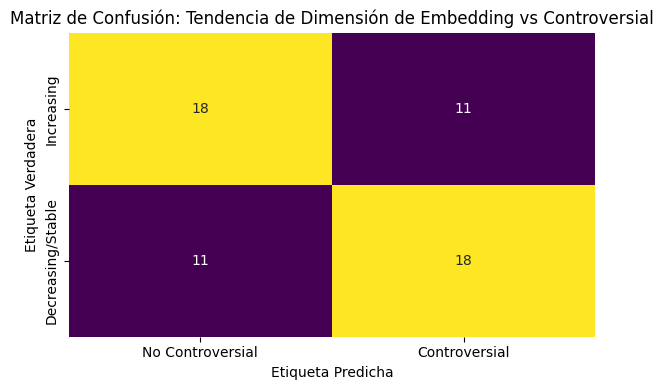

In [6]:
# Confusion matrix plot for decreasing_or_stable vs controversial
# decreasing_or_stable: True/False
# controversial: True/False

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Comment titles in english and translate titles and labels to spanish

trend_result['controversial'] = trend_result['controversial'].map({'True': True, 'False': False, True: True, False: False})

cm = confusion_matrix(
    trend_result["decreasing_or_stable"], 
    trend_result["controversial"]
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='viridis',  
    xticklabels=['No Controversial', 'Controversial'], 
    yticklabels=['Increasing', 'Decreasing/Stable'],
    cbar=False
)


plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión: Tendencia de Dimensión de Embedding vs Controversial')
plt.tight_layout()
plt.show()



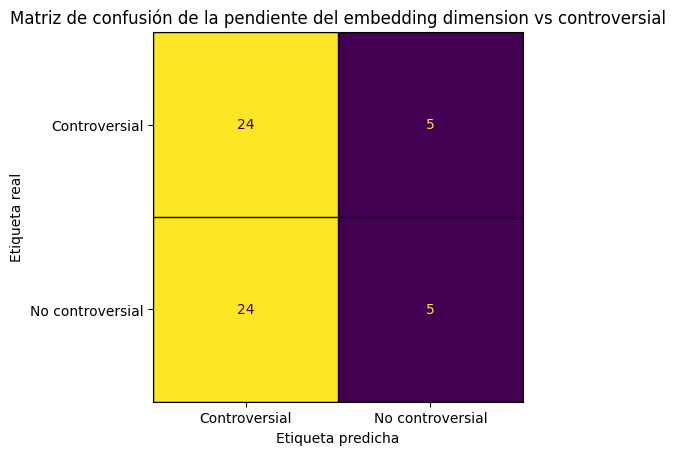

Accuracy: 0.5000
Precision: 0.5000
Recall: 0.8276
F1-Score: 0.6234


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = trend_result["controversial_numbers"]
y_pred = trend_result["embedding_dimension_slope"].apply(lambda x: 1 if x < 0 else 2)

cm = confusion_matrix(y_true, y_pred, labels=[1, 2])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Controversial", "No controversial"]
)

disp.plot(colorbar=False)
ax = disp.ax_

ax.set_xticks(np.arange(cm.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(cm.shape[0] + 1) - 0.5, minor=True)
ax.grid(which="minor", color="black", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

ax.set_xlabel("Etiqueta predicha")
ax.set_ylabel("Etiqueta real")
ax.set_title("Matriz de confusión de la pendiente del embedding dimension vs controversial")
plt.show()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label=1)
recall = recall_score(y_true, y_pred, pos_label=1)
f1 = f1_score(y_true, y_pred, pos_label=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


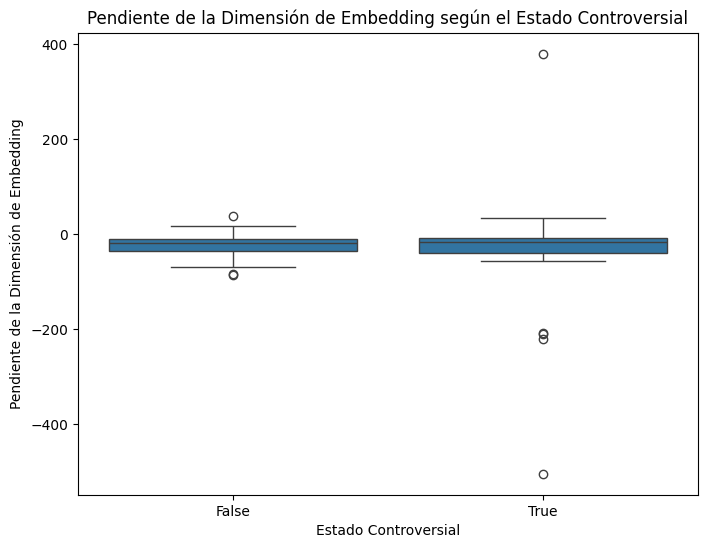

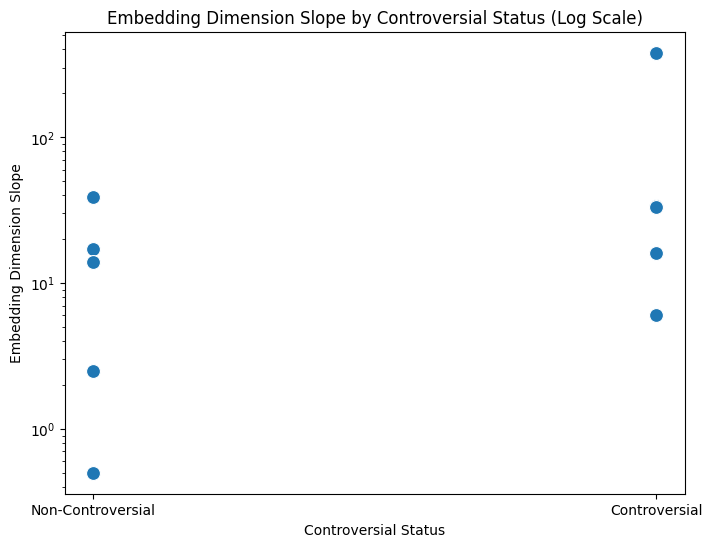

In [8]:
# Create a boxplot comparing embedding_dimension_slope for controversial vs non-controversial graphs (controversial: True/False)
plt.figure(figsize=(8, 6))
sns.boxplot(x="controversial", y="embedding_dimension_slope", data=trend_result)
# plt.title("Embedding Dimension Slope by Controversial Status")
plt.title("Pendiente de la Dimensión de Embedding según el Estado Controversial")
plt.xlabel("Estado Controversial")
plt.ylabel("Pendiente de la Dimensión de Embedding")
plt.show()

# Create a log scatter plot of embedding_dimension_slope for controversial vs non-controversial graphs
plt.figure(figsize=(8, 6))
sns.scatterplot(x="controversial_numbers", y="embedding_dimension_slope", data=trend_result, s=100)
plt.yscale("log")
plt.xticks([1, 2], ["Controversial", "Non-Controversial"])
plt.gca().invert_xaxis()
plt.title("Embedding Dimension Slope by Controversial Status (Log Scale)")  
plt.xlabel("Controversial Status")
plt.ylabel("Embedding Dimension Slope")
plt.show()

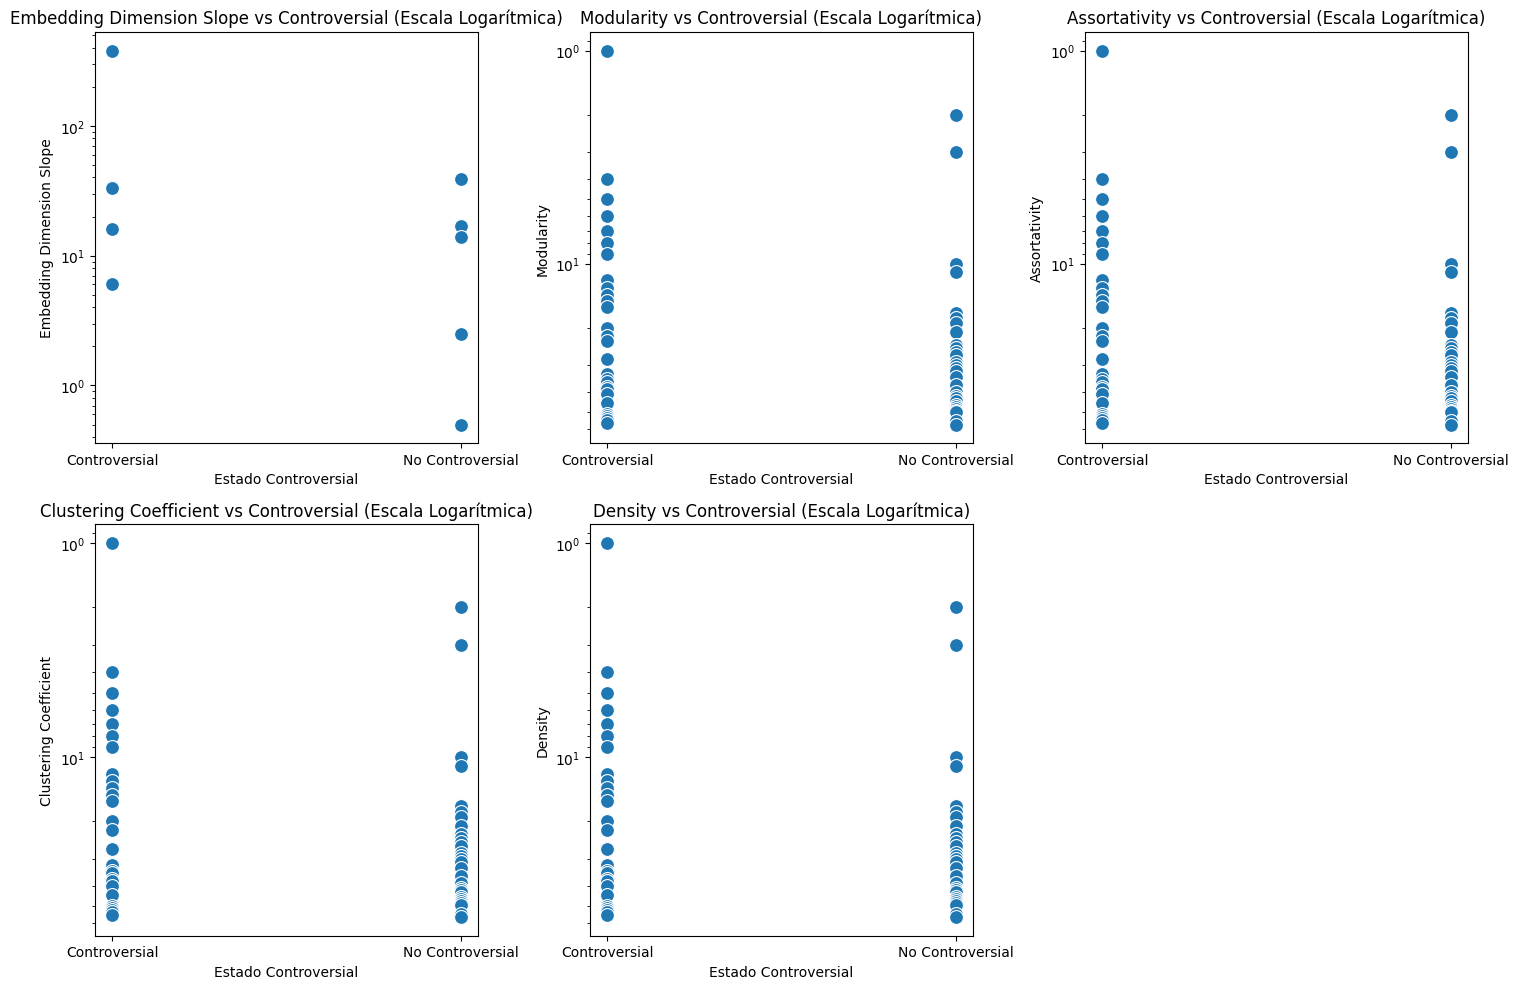

In [9]:
metrics = ["embedding_dimension_slope", "modularity", "assortativity", "clustering_coefficient", "density"]
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x="controversial_numbers", y=metric, data=trend_result, s=100)
    plt.xticks([1, 2], ["Controversial", "No Controversial"])
    plt.title(f"{metric.replace('_', ' ').title()} vs Controversial (Escala Logarítmica)")
    plt.xlabel("Estado Controversial")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.yscale("log")
plt.tight_layout()
plt.show()